# Práctica 0: Implementación de Perceptrón Multicapa desde Cero

Implementación de un perceptrón multicapa (MLP) sin usar frameworks de deep learning, solo NumPy.

**Objetivos:**
- Implementar forward pass y backpropagation manualmente
- Probar con XOR (problema no linealmente separable)
- Aplicar a problema de regresión

In [1]:
# Configuración inicial
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

np.random.seed(42)
plt.style.use('seaborn-v0_8')

print("Configuración inicial completada")

Configuración inicial completada


In [2]:
# Implementación del Perceptrón Multicapa
class MultiLayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size, 
                 learning_rate=0.01, epochs=5000, activation='relu', task='classification'):
        # Inicialización Xavier
        xavier_std = np.sqrt(2.0 / (input_size + hidden_size))
        self.W1 = np.random.normal(0, xavier_std, (input_size, hidden_size))
        self.b1 = np.zeros((1, hidden_size))
        
        xavier_std2 = np.sqrt(2.0 / (hidden_size + output_size))
        self.W2 = np.random.normal(0, xavier_std2, (hidden_size, output_size))
        self.b2 = np.zeros((1, output_size))
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.activation = activation
        self.task = task
        
        self.train_errors = []
        self.validation_errors = []
    
    def _activation_function(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
        elif self.activation == 'tanh':
            return np.tanh(x)
    
    def _activation_derivative(self, x):
        if self.activation == 'relu':
            return (x > 0).astype(float)
        elif self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'tanh':
            return 1 - x ** 2
    
    def _output_function(self, x):
        if self.task == 'classification':
            return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
        else:
            return x
    
    def _output_derivative(self, x):
        if self.task == 'classification':
            return x * (1 - x)
        else:
            return np.ones_like(x)
    
    def forward(self, X):
        # Capa oculta
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self._activation_function(self.z1)
        
        # Capa de salida
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.output = self._output_function(self.z2)
        
        return self.output
    
    def backward(self, X, y):
        m = X.shape[0]
        
        # Error capa de salida
        error = y - self.output
        d_output = error * self._output_derivative(self.output)
        
        # Error capa oculta
        error_hidden = d_output.dot(self.W2.T)
        d_hidden = error_hidden * self._activation_derivative(self.a1)
        
        # Actualizar pesos
        self.W2 += (self.a1.T.dot(d_output) / m) * self.learning_rate
        self.b2 += np.mean(d_output, axis=0, keepdims=True) * self.learning_rate
        self.W1 += (X.T.dot(d_hidden) / m) * self.learning_rate
        self.b1 += np.mean(d_hidden, axis=0, keepdims=True) * self.learning_rate
    
    def fit(self, X, y, X_val=None, y_val=None, verbose=True):
        start_time = time.time()
        
        for epoch in range(self.epochs):
            self.forward(X)
            self.backward(X, y)
            
            # Registrar errores
            mse_train = np.mean((y - self.output) ** 2)
            self.train_errors.append(mse_train)
            
            if X_val is not None and y_val is not None:
                val_pred = self.forward(X_val)
                mse_val = np.mean((y_val - val_pred) ** 2)
                self.validation_errors.append(mse_val)
            
            # Mostrar progreso
            if verbose and (epoch % (self.epochs // 10) == 0 or epoch == self.epochs - 1):
                if X_val is not None:
                    print(f"Época {epoch:4d}: Train MSE = {mse_train:.6f}, Val MSE = {mse_val:.6f}")
                else:
                    print(f"Época {epoch:4d}: MSE = {mse_train:.6f}")
        
        return time.time() - start_time
    
    def predict(self, X):
        output = self.forward(X)
        if self.task == 'classification':
            return (output > 0.5).astype(int)
        else:
            return output

print("Clase MultiLayerPerceptron definida")

Clase MultiLayerPerceptron definida


In [3]:
# Problema XOR - verificación del MLP
print("=== PROBLEMA XOR ===")

# Datos XOR
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([[0], [1], [1], [0]])

print("Datos XOR:")
for i in range(len(X_xor)):
    print(f"  {X_xor[i]} -> {y_xor[i][0]}")

# Configuraciones a probar
configs_xor = [
    {'hidden_size': 2, 'learning_rate': 0.1, 'epochs': 1000, 'activation': 'sigmoid'},
    {'hidden_size': 4, 'learning_rate': 0.1, 'epochs': 1000, 'activation': 'sigmoid'},
    {'hidden_size': 8, 'learning_rate': 0.05, 'epochs': 2000, 'activation': 'relu'},
    {'hidden_size': 10, 'learning_rate': 0.01, 'epochs': 5000, 'activation': 'tanh'}
]

print("\nEntrenando diferentes configuraciones:")

mejor_accuracy = 0
mejor_modelo_xor = None

for i, config in enumerate(configs_xor):
    print(f"Config {i+1}: {config}")
    
    mlp = MultiLayerPerceptron(
        input_size=2,
        output_size=1,
        task='classification',
        **config
    )
    
    tiempo = mlp.fit(X_xor, y_xor, verbose=False)
    predicciones = mlp.predict(X_xor)
    accuracy = np.mean(y_xor == predicciones)
    
    print(f"  Tiempo: {tiempo:.3f}s | Accuracy: {accuracy:.4f}")
    print(f"  Predicciones: {predicciones.flatten()}")
    
    if accuracy > mejor_accuracy:
        mejor_accuracy = accuracy
        mejor_modelo_xor = mlp
    
    print()

print(f"Mejor accuracy XOR: {mejor_accuracy:.4f}")

=== PROBLEMA XOR ===
Datos XOR:
  [0 0] -> 0
  [0 1] -> 1
  [1 0] -> 1
  [1 1] -> 0

Entrenando diferentes configuraciones:
Config 1: {'hidden_size': 2, 'learning_rate': 0.1, 'epochs': 1000, 'activation': 'sigmoid'}
  Tiempo: 0.048s | Accuracy: 0.5000
  Predicciones: [1 0 1 0]

Config 2: {'hidden_size': 4, 'learning_rate': 0.1, 'epochs': 1000, 'activation': 'sigmoid'}
  Tiempo: 0.041s | Accuracy: 0.5000
  Predicciones: [1 1 0 0]

Config 3: {'hidden_size': 8, 'learning_rate': 0.05, 'epochs': 2000, 'activation': 'relu'}
  Tiempo: 0.069s | Accuracy: 1.0000
  Predicciones: [0 1 1 0]

Config 4: {'hidden_size': 10, 'learning_rate': 0.01, 'epochs': 5000, 'activation': 'tanh'}
  Tiempo: 0.177s | Accuracy: 0.7500
  Predicciones: [0 1 0 0]

Mejor accuracy XOR: 1.0000


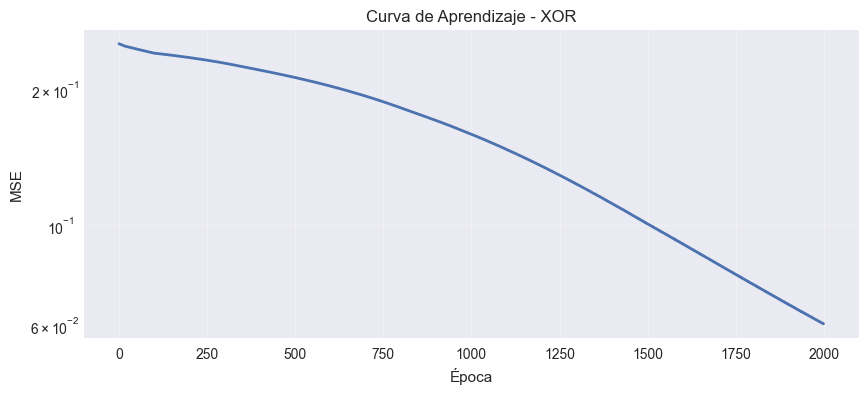

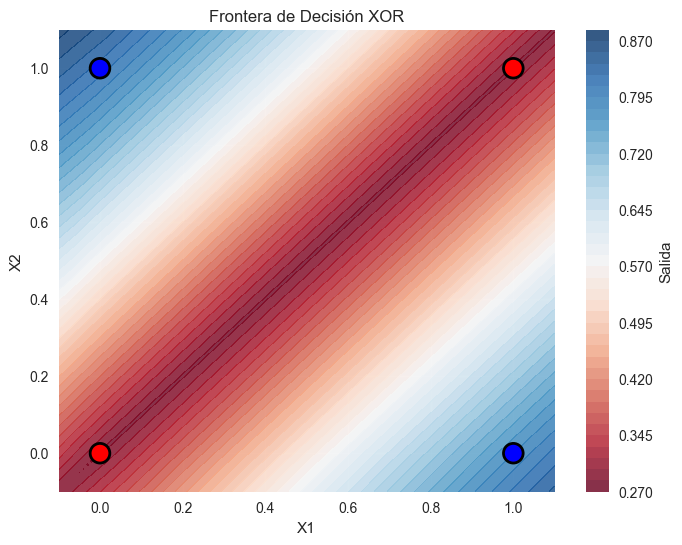

In [4]:
# Visualizar frontera de decisión XOR
def plot_decision_boundary(model, X, y, title="Frontera de Decisión"):
    h = 0.01
    x_min, x_max = -0.1, 1.1
    y_min, y_max = -0.1, 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.forward(mesh_points)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, levels=50, alpha=0.8, cmap='RdBu')
    plt.colorbar(label='Salida')
    
    colors = ['red' if label == 0 else 'blue' for label in y.flatten()]
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=200, edgecolors='black', linewidth=2)
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

# Curva de aprendizaje
plt.figure(figsize=(10, 4))
plt.plot(mejor_modelo_xor.train_errors, linewidth=2)
plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Curva de Aprendizaje - XOR')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

plot_decision_boundary(mejor_modelo_xor, X_xor, y_xor, "Frontera de Decisión XOR")

In [5]:
# Problema de Regresión
print("=== PROBLEMA DE REGRESIÓN ===")

# Cargar o generar datos
try:
    data_train = pd.read_parquet('data_train.parquet')
    data_test = pd.read_parquet('data_test.parquet')
    print("Datos cargados desde archivos parquet")
except:
    # Generar datos sintéticos
    print("Generando datos sintéticos...")
    X_range = np.linspace(-5, 5, 1000)
    y_function = X_range ** 3 * 0.001 + np.sin(X_range * 2) * 0.5 + np.random.normal(0, 0.1, 1000)
    
    split = int(0.8 * len(X_range))
    data_train = pd.DataFrame({'X': X_range[:split], 'Y': y_function[:split]})
    data_test = pd.DataFrame({'X': X_range[split:], 'Y': y_function[split:]})

X_train = data_train[['X']].values
y_train = data_train[['Y']].values
X_test = data_test[['X']].values
y_test = data_test[['Y']].values

print(f"Train: {X_train.shape[0]} muestras")
print(f"Test: {X_test.shape[0]} muestras")

# Normalización
X_mean, X_std = X_train.mean(), X_train.std()
y_mean, y_std = y_train.mean(), y_train.std()

X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std
y_train_norm = (y_train - y_mean) / y_std
y_test_norm = (y_test - y_mean) / y_std

print(f"Normalización aplicada: X_mean={X_mean:.3f}, X_std={X_std:.3f}")

=== PROBLEMA DE REGRESIÓN ===
Datos cargados desde archivos parquet
Train: 86 muestras
Test: 1000 muestras
Normalización aplicada: X_mean=-0.045, X_std=3.112


In [6]:
# Búsqueda de hiperparámetros para regresión
configs_regression = [
    {'hidden_size': 8, 'learning_rate': 0.01, 'epochs': 3000, 'activation': 'relu'},
    {'hidden_size': 16, 'learning_rate': 0.005, 'epochs': 4000, 'activation': 'relu'},
    {'hidden_size': 32, 'learning_rate': 0.003, 'epochs': 5000, 'activation': 'relu'},
    {'hidden_size': 16, 'learning_rate': 0.01, 'epochs': 3000, 'activation': 'tanh'},
    {'hidden_size': 24, 'learning_rate': 0.008, 'epochs': 4000, 'activation': 'tanh'},
    {'hidden_size': 12, 'learning_rate': 0.02, 'epochs': 2500, 'activation': 'sigmoid'}
]

print("Probando configuraciones para regresión:")

resultados = []
mejor_r2 = -float('inf')
mejor_modelo_reg = None

for i, config in enumerate(configs_regression):
    print(f"Config {i+1}: {config}")
    
    mlp = MultiLayerPerceptron(
        input_size=1,
        output_size=1,
        task='regression',
        **config
    )
    
    tiempo = mlp.fit(X_train_norm, y_train_norm, verbose=False)
    
    # Evaluar
    y_pred_norm = mlp.predict(X_test_norm)
    y_pred = y_pred_norm * y_std + y_mean  # Desnormalizar
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    resultados.append({
        'config': config,
        'tiempo': tiempo,
        'mse': mse,
        'r2': r2
    })
    
    print(f"  Tiempo: {tiempo:.3f}s | MSE: {mse:.6f} | R2: {r2:.6f}")
    
    if r2 > mejor_r2:
        mejor_r2 = r2
        mejor_modelo_reg = mlp
    
    print()

print(f"Mejor R2 Score: {mejor_r2:.6f}")

Probando configuraciones para regresión:
Config 1: {'hidden_size': 8, 'learning_rate': 0.01, 'epochs': 3000, 'activation': 'relu'}
  Tiempo: 0.096s | MSE: 0.130183 | R2: -0.303137

Config 2: {'hidden_size': 16, 'learning_rate': 0.005, 'epochs': 4000, 'activation': 'relu'}
  Tiempo: 0.126s | MSE: 0.125355 | R2: -0.254807

Config 3: {'hidden_size': 32, 'learning_rate': 0.003, 'epochs': 5000, 'activation': 'relu'}
  Tiempo: 0.175s | MSE: 0.126776 | R2: -0.269025

Config 4: {'hidden_size': 16, 'learning_rate': 0.01, 'epochs': 3000, 'activation': 'tanh'}
  Tiempo: 0.110s | MSE: 0.129257 | R2: -0.293863

Config 5: {'hidden_size': 24, 'learning_rate': 0.008, 'epochs': 4000, 'activation': 'tanh'}
  Tiempo: 0.161s | MSE: 0.125561 | R2: -0.256870

Config 6: {'hidden_size': 12, 'learning_rate': 0.02, 'epochs': 2500, 'activation': 'sigmoid'}
  Tiempo: 0.104s | MSE: 0.112119 | R2: -0.122311

Mejor R2 Score: -0.122311


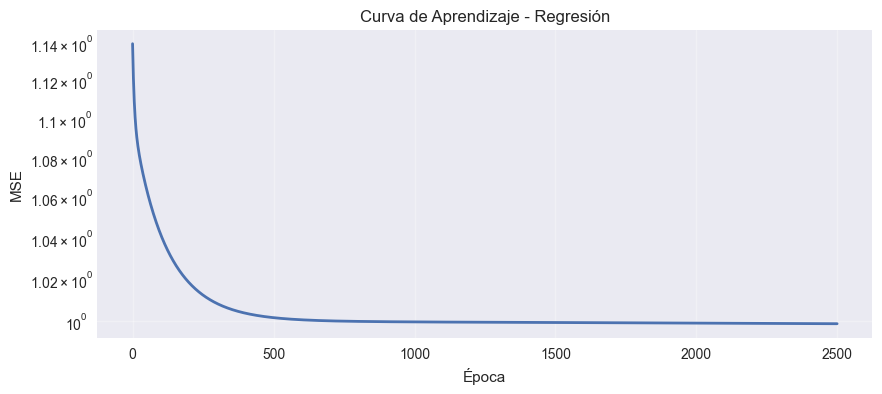

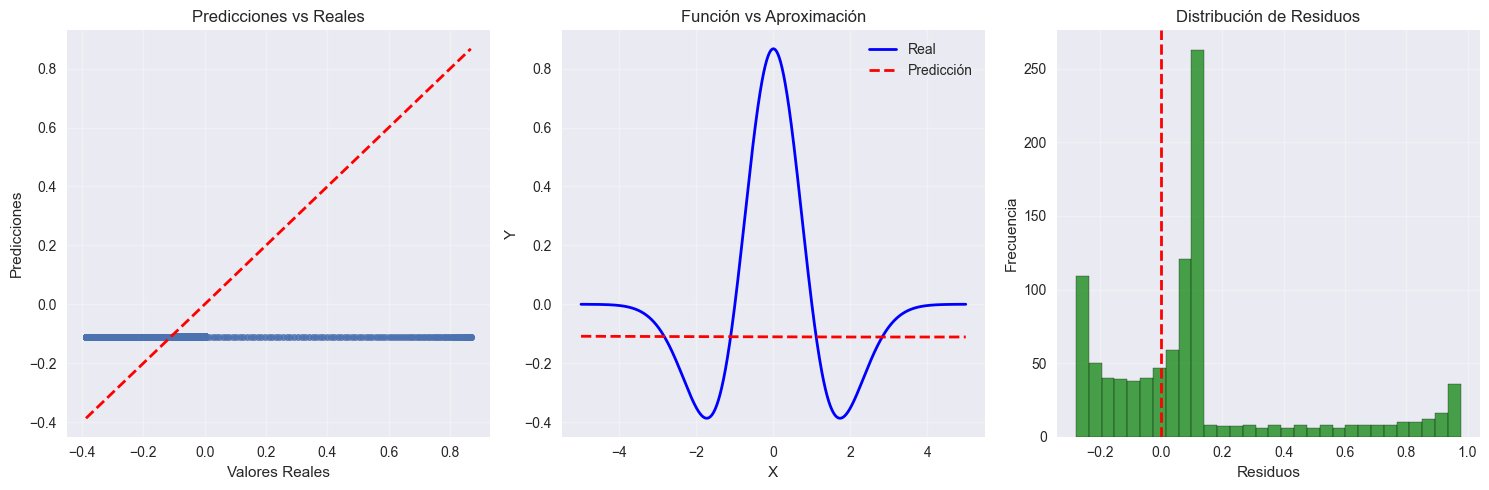

Métricas finales:
  MSE: 0.112119
  MAE: 0.224322
  R²: -0.122311


In [7]:
# Visualización de resultados de regresión

# Curva de aprendizaje
plt.figure(figsize=(10, 4))
plt.plot(mejor_modelo_reg.train_errors, linewidth=2)
plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Curva de Aprendizaje - Regresión')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

# Predicciones vs reales
y_pred_norm = mejor_modelo_reg.predict(X_test_norm)
y_pred = y_pred_norm * y_std + y_mean

plt.figure(figsize=(15, 5))

# Scatter plot
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Reales')
plt.grid(True, alpha=0.3)

# Función vs aproximación
plt.subplot(1, 3, 2)
indices = np.argsort(X_test.flatten())
plt.plot(X_test[indices], y_test[indices], 'b-', label='Real', linewidth=2)
plt.plot(X_test[indices], y_pred[indices], 'r--', label='Predicción', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Función vs Aproximación')
plt.legend()
plt.grid(True, alpha=0.3)

# Residuos
plt.subplot(1, 3, 3)
residuos = y_test - y_pred
plt.hist(residuos, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuos')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Métricas finales
mse_final = mean_squared_error(y_test, y_pred)
mae_final = mean_absolute_error(y_test, y_pred)
r2_final = r2_score(y_test, y_pred)

print(f"Métricas finales:")
print(f"  MSE: {mse_final:.6f}")
print(f"  MAE: {mae_final:.6f}")
print(f"  R²: {r2_final:.6f}")


Comparación de todas las configuraciones:
 Config  Hidden Size  Learning Rate  Épocas Activación Tiempo (s)      MSE  R² Score
      1            8          0.010    3000       relu      0.096 0.130183 -0.303137
      2           16          0.005    4000       relu      0.126 0.125355 -0.254807
      3           32          0.003    5000       relu      0.175 0.126776 -0.269025
      4           16          0.010    3000       tanh      0.110 0.129257 -0.293863
      5           24          0.008    4000       tanh      0.161 0.125561 -0.256870
      6           12          0.020    2500    sigmoid      0.104 0.112119 -0.122311


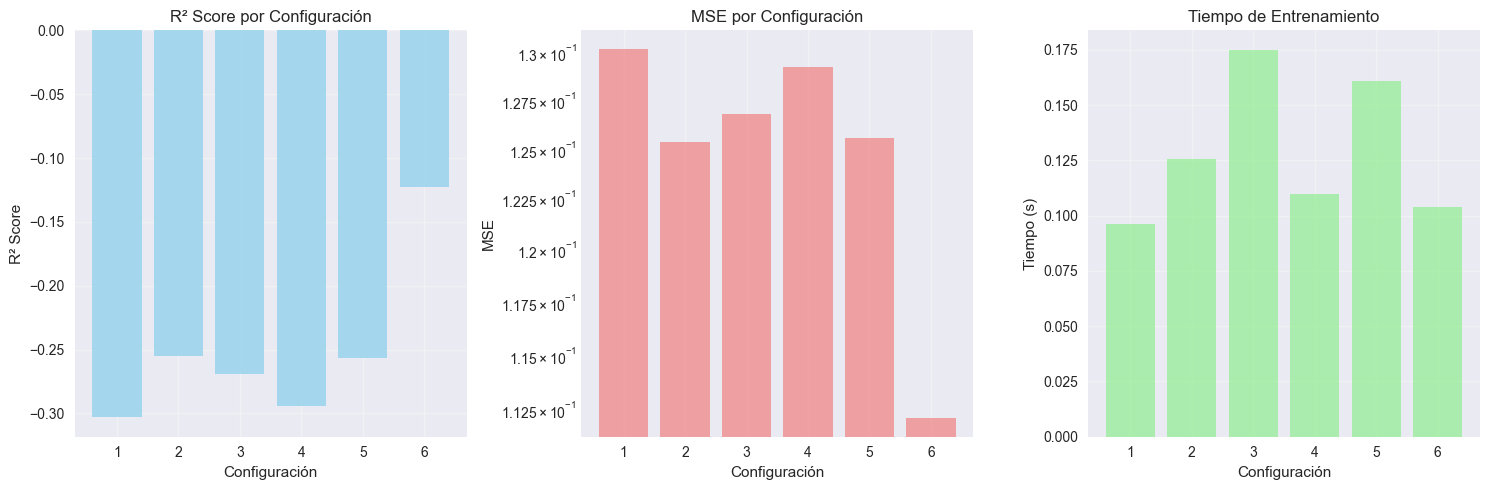

In [8]:
# Tabla comparativa de todas las configuraciones
df_resultados = pd.DataFrame([
    {
        'Config': i+1,
        'Hidden Size': r['config']['hidden_size'],
        'Learning Rate': r['config']['learning_rate'],
        'Épocas': r['config']['epochs'],
        'Activación': r['config']['activation'],
        'Tiempo (s)': f"{r['tiempo']:.3f}",
        'MSE': f"{r['mse']:.6f}",
        'R² Score': f"{r['r2']:.6f}"
    }
    for i, r in enumerate(resultados)
])

print("\nComparación de todas las configuraciones:")
print(df_resultados.to_string(index=False))

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

configs_num = range(1, len(resultados) + 1)
r2_scores = [r['r2'] for r in resultados]
mse_scores = [r['mse'] for r in resultados]
tiempos = [r['tiempo'] for r in resultados]

axes[0].bar(configs_num, r2_scores, color='skyblue', alpha=0.7)
axes[0].set_title('R² Score por Configuración')
axes[0].set_xlabel('Configuración')
axes[0].set_ylabel('R² Score')
axes[0].grid(True, alpha=0.3)

axes[1].bar(configs_num, mse_scores, color='lightcoral', alpha=0.7)
axes[1].set_title('MSE por Configuración')
axes[1].set_xlabel('Configuración')
axes[1].set_ylabel('MSE')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

axes[2].bar(configs_num, tiempos, color='lightgreen', alpha=0.7)
axes[2].set_title('Tiempo de Entrenamiento')
axes[2].set_xlabel('Configuración')
axes[2].set_ylabel('Tiempo (s)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()